<a href="https://colab.research.google.com/github/brathod2/Streaming-DMD-integrated-within-NEK5000/blob/main/Convolution_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Python 3.7
#Setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow.keras.backend as kb
#from tensorflow.keras.layers import concatenate
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pickle

from PIL import Image, ImageDraw
from scipy.io import loadmat
import h5py
!pip install mat73
import mat73
!pip install tensorboard
#Swish Function Setup
#from tensorflow.keras.backend import sigmoid
#def swish(x, beta = 1):
# return (x * sigmoid(beta * x))
#from tensorflow.keras.utils import get_custom_objects
#from tensorflow.keras.layers import Activation
#get_custom_objects().update({'swish': Activation(swish)})


2.5.0


x_modes (11, 64, 64, 32)
x_evals (11, 16, 2)
x_commenc (11, 64, 64)
Before normalizing
x-commenc mean 0.0013140170432539757
x-modes mean 8.859466697877875e-06
x-evals mean 0.10775986507329406
x-commenc std 0.0019731510290182924
x-modes std 0.0007920029776871449
x-evals std 0.3794937238443451
After scaling
x-commenc mean 1.314017043253976
x-modes mean 4.800058709094915e-18
x-evals mean 1.0775986507329407
x-commenc std 1.973151029018292
x-modes std 1.0
x-evals std 3.7949372384434503
x_modes (11, 64, 64, 32, 1)
x_evals (11, 16, 2, 1)
x_commenc (11, 64, 64, 1)
34
xTrain (9, 256, 256, 1)
xmodes_train (9, 64, 64, 32, 1)
xevals_train (9, 16, 2, 1)
train_porosity (9, 1, 1)
x_commenc (9, 64, 64, 1)


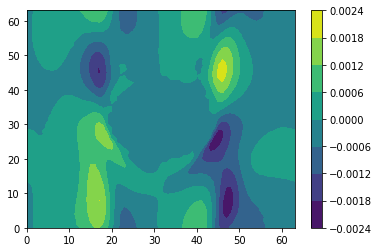

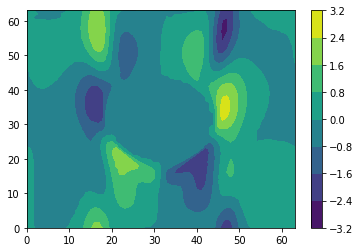

In [ ]:
## Training data Prep

cases=11   #Number of Samples



x_modes=mat73.loadmat('x_modes.mat')
y_modes=mat73.loadmat('y_modes.mat')
z_modes=mat73.loadmat('z_modes.mat')
x_evals=mat73.loadmat('x_evals.mat')
y_evals=mat73.loadmat('y_evals.mat')
z_evals=mat73.loadmat('z_evals.mat')
x_commenc=mat73.loadmat('x_commenc.mat')
y_commenc=mat73.loadmat('y_commenc.mat')
z_commenc=mat73.loadmat('z_commenc.mat')


x_modes=x_modes.get('x_modes')
y_modes=y_modes.get('y_modes')
z_modes=z_modes.get('z_modes')
x_evals=x_evals.get('x_evals')
y_evals=y_evals.get('y_evals')
z_evals=z_evals.get('z_evals')
x_commenc=x_commenc.get('x_commenc')
y_commenc=y_commenc.get('y_commenc')
z_commenc=z_commenc.get('z_commenc')

print('x_modes',np.shape(x_modes))
print('x_evals',np.shape(x_evals))
print('x_commenc',np.shape(x_commenc))
# print(x_evals)

plt.figure(num=1)
cs=plt.contourf(x_modes[0,:,:,0])
plt.colorbar(cs)
plt.close

print('Before normalizing')
print('x-commenc mean',np.mean(x_commenc[:,:,:]))
print('x-modes mean',np.mean(x_modes[:,:,:,:]))
print('x-evals mean',np.mean(x_evals[:,:,:]))
print('x-commenc std',np.std(x_commenc[:,:,:]))
print('x-modes std',np.std(x_modes[:,:,:,:]))
print('x-evals std',np.std(x_evals[:,:,:]))

x_evals=x_evals/0.1
x_modes=(x_modes-np.mean(x_modes))/np.std(x_modes)
x_commenc=x_commenc/0.001

print('After scaling')
print('x-commenc mean',np.mean(x_commenc[:,:,:]))
print('x-modes mean',np.mean(x_modes[:,:,:,:]))
print('x-evals mean',np.mean(x_evals[:,:,:]))
print('x-commenc std',np.std(x_commenc[:,:,:]))
print('x-modes std',np.std(x_modes[:,:,:,:]))
print('x-evals std',np.std(x_evals[:,:,:]))


plt.figure(num=2)
cs=plt.contourf(x_modes[0,:,:,1])
plt.colorbar(cs)
plt.close

x_modes=np.expand_dims(x_modes,4)
x_evals=np.expand_dims(x_evals,3)
x_commenc=np.expand_dims(x_commenc,3)

y_modes=np.expand_dims(y_modes,4)
y_evals=np.expand_dims(y_evals,3)
y_commenc=np.expand_dims(y_commenc,3)

z_modes=np.expand_dims(z_modes,4)
z_evals=np.expand_dims(z_evals,3)
z_commenc=np.expand_dims(z_commenc,3)



print('x_modes',np.shape(x_modes))
print('x_evals',np.shape(x_evals))
print('x_commenc',np.shape(x_commenc))


xData=mat73.loadmat('xData.mat')
xData=(xData.get('xData'))
xData=np.expand_dims(xData,3)
porosity=mat73.loadmat('porosity.mat')
porosity=porosity.get('porosity')
in2=np.zeros((cases,1,1))

for i in range(cases):
  in2[i,:,0]=in2[i,:,0]+porosity[i]

#Split into training and testing datasets
# Training indices --v, testing indices--v1
v=np.array([0,1,2,4,5,6,7,9,10])
v1=np.array([3,8])
# v=np.array([1,7])

# in2=porosity[v]
xTrain = xData[v]
xTest = xData[v1]

porosity_train=np.zeros((len(v),1,1))
porosity_test=np.zeros((len(v1),1,1))
porosity_train[:,:,0]=in2[v,:,0]
porosity_test[:,:,0]=in2[v1,:,0]


xmodes_train = x_modes[v,:,:,:,:]
ymodes_train=y_modes[v,:,:,:,:]
zmodes_train=z_modes[v,:,:,:,:]

xevals_train = x_evals[v,:,:,:]
yevals_train=y_evals[v,:,:,:]
zevals_train=z_evals[v,:,:,:]

xcommenc_train = x_commenc[v,:,:,:]
ycommenc_train=y_commenc[v,:,:,:]
zcommenc_train=z_commenc[v,:,:,:]

xmodes_test = x_modes[v1,:,:,:]
ymodes_test=y_modes[v1,:,:,:]
zmodes_test=z_modes[v1,:,:,:]

xevals_test = x_evals[v1,:,:,:]
yevals_test=y_evals[v1,:,:,:]
zevals_test=z_evals[v1,:,:,:]

xcommenc_test = x_commenc[v1,:,:,:]
ycommenc_test=y_commenc[v1,:,:,:]
zcommenc_test=z_commenc[v1,:,:,:]

xmodes_output=[]
for i in range(32):
  name='xmodes'+str(i)
  name=np.zeros((9,64,64,1))
  name[:,:,:,:]=xmodes_train[:,:,:,i,:]
  xmodes_output.append(name)

xmodes_output.append(xcommenc_train)
xmodes_output.append(xevals_train)
print(len(xmodes_output))



print('xTrain',np.shape(xTrain))
print('xmodes_train',np.shape(xmodes_train))
print('xevals_train',np.shape(xevals_train))
print('train_porosity',np.shape(porosity_train))
print('x_commenc',np.shape(xcommenc_train))

In [ ]:

class custom_model(): 

  def deconv_hidden_layer_for_evals(self,x,rmax):
    # x=layers.Dense(4096)(x)
    # x=keras.activations.swish(x)
    x=layers.Dense(rmax*2)(x)
    x=keras.activations.swish(x)
    x=layers.Reshape((rmax,2,1))(x)
    return x

  def deconv_hidden_layers_for_commenc(self,x,outpt_name,cust_mean,cust_std,initialize_mean,initialize_std):
    # initializer=keras.initializers.RandomNormal(mean=0,stddev=initialize_std[i-1])
    x=layers.Dense(4096)(x)
    x=keras.activations.swish(x)
    x=layers.Reshape((4,4,256))(x)
    x=layers.Conv2DTranspose(256,(4,4),strides=(4,4),padding="valid",name='Layer-1-'+outpt_name,kernel_initializer=keras.initializers.he_normal())(x)
    x=keras.activations.swish(x)
    x=layers.Conv2DTranspose(256,(2,2),strides=(2,2),padding="valid",name='Layer-2-'+outpt_name,kernel_initializer=keras.initializers.he_normal())(x)
    x=keras.activations.swish(x)
    x=layers.Conv2DTranspose(1,(2,2),strides=(2,2),padding="valid",name='Layer-3-'+outpt_name,kernel_initializer=keras.initializers.he_normal())(x)
    return x

  def deconv_hidden_layers_for_modes(self,x,outpt_name,cust_mean,cust_std,initialize_mean,initialize_std,i):
    # initializer=keras.initializers.RandomNormal(mean=0,stddev=initialize_std[i-1])
    x=layers.Dense(4096)(x)
    x=keras.activations.swish(x)
    x=layers.Reshape((4,4,256))(x)
    x=layers.Conv2DTranspose(256,(4,4),strides=(4,4),padding="valid",name='Layer-1-'+outpt_name,kernel_initializer=keras.initializers.he_normal())(x)
    x=keras.activations.swish(x)
    x=layers.Conv2DTranspose(256,(2,2),strides=(2,2),padding="valid",name='Layer-2-'+outpt_name,kernel_initializer=keras.initializers.he_normal())(x)
    x=keras.activations.swish(x)
    x=layers.Conv2DTranspose(1,(2,2),strides=(2,2),padding="valid",name='Layer-3-'+outpt_name,kernel_initializer=keras.initializers.he_normal())(x)
   
    # x=keras.activations.swish(x)
    # x=layers.Average(name=outpt_name)(x)

    # x=layers.Conv2DTranspose(1,(1,1),strides=(1,1),padding="valid",name=outpt_name)(x)
    # x=layers.Conv2DTranspose(32,(4,4),strides=(4,4),padding="valid",activation="relu",name='Layer-3-'+outpt_name,kernel_initializer=keras.initializers.HeNormal())(x)
    # x=layers.Conv2DTranspose(1,(1,1),strides=(1,1),padding="valid",name=outpt_name,activation=None)(x)
    # x=layers.Conv2DTranspose(1,(2,2),strides=(2,2),padding="valid",name=outpt_name,kernel_initializer=keras.initializers.random_normal(mean=cust_mean,stddev=cust_std),bias_initializer=keras.initializers.random_normal(mean=cust_mean,stddev=cust_std))(x)
    return x

  def conv_hidden_layers(self,x,in2,cust_mean,cust_std):
    x1=layers.Conv2D(256,(4,4),strides=(4,4),padding='valid',name="1st_Conv_Layer",kernel_initializer=keras.initializers.he_normal())(x)
    x1=keras.activations.swish(x1)
    x2=layers.Conv2D(256,(4,4),strides=(4,4),padding='valid',name="2nd_Conv_Layer",kernel_initializer=keras.initializers.he_normal())(x1)
    x2=keras.activations.swish(x2)
    x3=layers.Conv2D(256,(4,4),strides=(4,4),padding='valid',name="3rd_Conv_Layer",kernel_initializer=keras.initializers.he_normal())(x2)
    x3=keras.activations.swish(x3)
    # x4=layers.Conv2D(16,(2,2),strides=(2,2),padding='valid',activation='relu',name="4th_Conv_Layer",kernel_initializer=keras.initializers.HeNormal())(x3)
    # x5=layers.Conv2D(32,(2,2),strides=(2,2),padding='valid',activation='relu',name="5th_Conv_Layer",kernel_initializer=keras.initializers.HeNormal())(x4)
    
  
    flat1 = layers.Flatten()(x3)
    flat2 = layers.Flatten()(in2)
    merge = layers.concatenate([flat1, flat2])
    # x=layers.Dense(4096)(merge)
    # merge=keras.activations.swish(x)  

    
    
    return merge
  
  def custom_model_build(self,branches,rmax,cust_mean,cust_std,initialize_mean,initialize_std):
    input_1=layers.Input(shape=(256,256,1),name='input_1')
    input_2=layers.Input(shape=(1,1),name='input_2')
    # in2=layers.Input(shape=(1024,1))
    x=self.conv_hidden_layers(input_1,input_2,cust_mean,cust_std)
    
    outpt_1=[] 
    for i in range (1,branches+1):
      outpt_name='outpt'+str(i)
      #  cust_mean=initialize_mean[i-1]
      #  cust_std=initialize_std[i-1]
      outpt_name=self.deconv_hidden_layers_for_modes(x,outpt_name,cust_mean,cust_std,initialize_mean,initialize_std,i)
      outpt_1.append(outpt_name)


    # outpt_2=[]
    outpt_commenc=self.deconv_hidden_layers_for_commenc(x,'commenc',cust_mean,cust_std,initialize_mean,initialize_std)
    outpt_1.append(outpt_commenc)

    # outpt_3=[]
    outpt_evals=self.deconv_hidden_layer_for_evals(x,rmax)
    outpt_1.append(outpt_evals)

    model=tf.keras.models.Model()
    model=tf.keras.models.Model(inputs=[input_1,input_2],outputs=outpt_1)
    # print([outpt_1,outpt_2,outpt_3])
    return model

rmax=16
cust_mean=0.00045220536515925544
cust_std=0.0012999794042310709
initialize_mean=0
initialize_std=0
model=custom_model().custom_model_build(rmax*2,rmax,cust_mean,cust_std,initialize_mean,initialize_std)  
print(model.summary())
tf.keras.utils.plot_model(model,to_file='deep_model3.png',show_shapes=True)



loss_fn=tf.keras.losses.MeanSquaredError()


model.compile(optimizer='Adam',loss=loss_fn,metrics=['mae','mse','MeanAbsolutePercentageError'])

#Checkpoints
cp_path = 'deep_model.cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=cp_path, monitor='val_loss', verbose=0, save_best_only=False,
save_weights_only=True, mode='min', save_freq=9000
)

print(np.shape(xcommenc_train))
print(np.shape(xmodes_train))
print(np.shape(xTrain))
print(np.shape(porosity_train))
# fit_history=model.fit([xTrain,porosity_train],xmodes_train,epochs=400,callbacks=[cp_callback])


fit_history=model.fit([xTrain,porosity_train],xmodes_output,epochs=400,callbacks=[cp_callback])

# fit_history=model.fit([xTrain,, , epochs=400, callbacks=[cp_callback])


In [ ]:
# print(model.summary())
# model.save('best-network-xmodes.model')
model = tf.keras.models.load_model('best-network-xmodes.model')

In [ ]:
case_pred=0

for j in range(len(v1)):
  case_pred=v1[j]  
  # Predicting for data
  data=np.zeros((1,256,256,1)) 
  predict_por=np.zeros((1,1,1))
  data[0,:,:,0]=xData[case_pred,:,:,0]
  exact_data=xevals_train[case_pred,:,:,0]
  predict_por[:,:,0]=porosity_train[case_pred,:,0] 

  layer_id='reshape_66'
  
  extractor=keras.Model(inputs=model.input,outputs=model.get_layer(layer_id).output)
  intermediate_values=extractor.predict([data,predict_por])
  print(intermediate_values[0,:,:,0])
  print(exact_data)
  fig, ax = plt.subplots(1, 2)
  fig.set_size_inches(20,5)
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  # CS1=ax[0].plot(intermediate_values[0,:,:,0]*0.1,'ro')
  ax[0].scatter(intermediate_values[0,:,0,0]*0.1,intermediate_values[0,:,1,0]*0.1)
 
  # CS2=ax[1].plot(np.ndarray.flatten(intermediate_values),'ro')
  ax[1].scatter(exact_data[:,0]*0.1,exact_data[:,1]*0.1)
   # fig.colorbar(CS1, ax=ax[0])
  # fig.colorbar(CS3, ax=ax[2])
  plt.savefig(layer_id,bbox_inches='tight')


In [ ]:
# Subroutine to create images of layer outputs

# Predicting for data

for case_pred in range(0,11):

  fig, ax = plt.subplots(rmax*2,2)
  fig.set_size_inches(10,100)
    
  for j in range (rmax*2):
    mode=j 
    data=np.zeros((1,256,256,1)) 
    predict_por=np.zeros((1,1,1))
    data[0,:,:,0]=xData[case_pred,:,:,0]
    exact_data=x_modes[case_pred,:,:,mode,0]
    predict_por[:,:,0]=in2[case_pred,:,0] 

    layer_id='Layer-3-outpt'+str(mode+1)
    
    extractor=keras.Model(inputs=model.input,outputs=model.get_layer(layer_id).output)
    intermediate_values=extractor.predict([data,predict_por])
    print(intermediate_values.shape)

    CS=ax[j,0].contourf(intermediate_values[0,:,:,0])
    ax[j,0].set_title('CNN-predicted-mode-'+str(j+1))
    fig.colorbar(CS, ax=ax[j,0])
    CS=ax[j,1].contourf(exact_data)
    ax[j,1].set_title('Ground-truth-DMD-mode-'+str(j+1))
    fig.colorbar(CS, ax=ax[j,1])

  plt.savefig('Porosity-case-number-'+str(case_pred+1),bbox_inches='tight')
  plt.close()

In [ ]:
# Subroutine to create images of layer outputs

# Predicting for data

fig, ax = plt.subplots(len(v1),2,sharex='col', sharey='row')
fig.set_size_inches(11,9)

count=-1
for j in range(2):
  case_pred=v1[j]
  count=count+1
  data=np.zeros((1,256,256,1)) 
  predict_por=np.zeros((1,1,1))
  data[0,:,:,0]=xData[case_pred,:,:,0]
  exact_data=x_commenc[case_pred,:,:,0]
  predict_por[:,:,0]=in2[case_pred,:,0] 

  layer_id='Layer-3-commenc'
    
  extractor=keras.Model(inputs=model.input,outputs=model.get_layer(layer_id).output)
  intermediate_values=extractor.predict([data,predict_por])
  print(intermediate_values.shape)

  CS=ax[count,0].contourf(np.transpose(intermediate_values[0,:,:,0]*0.001))
  ax[count,0].set_title('CNN-predicted-for-Case-porosity-'+str(in2[case_pred,:,0]))

  fig.colorbar(CS, ax=ax[count,0])
  CS=ax[count,1].contourf(np.transpose(exact_data*0.001))
  ax[count,1].set_title('Ground-truth-for-Case-porosity-'+str(in2[case_pred,:,0]))
  fig.colorbar(CS, ax=ax[count,1])

plt.savefig('x-modes-commenc',bbox_inches='tight')
plt.close()